In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
def load_processed_data():
    """Load preprocessed training data"""
    train_data = pd.read_csv('processed_data/train_cleaned.csv')
    
    # Separate features and target
    X = train_data.drop('Item_Outlet_Sales', axis=1)
    y = train_data['Item_Outlet_Sales']
    
    print(f"Training data shape: {train_data.shape}")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"\nFeature columns: {list(X.columns)}")
    
    return X, y

X, y = load_processed_data()


Training data shape: (8523, 16)
Features shape: (8523, 15)
Target shape: (8523,)

Feature columns: ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category', 'Outlet_Years', 'Item_Visibility_MeanRatio', 'Item_Type_Combined', 'Price_per_Unit_Weight', 'Outlet_Type_Size']


In [3]:
# Split data for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Target distribution - Mean: {y.mean():.2f}, Std: {y.std():.2f}")


Training set: (6818, 15)
Validation set: (1705, 15)
Target distribution - Mean: 2181.29, Std: 1706.50


In [4]:
def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """Evaluate model performance on train and validation sets"""
    # Train predictions
    y_train_pred = model.predict(X_train)
    train_rmse = calculate_rmse(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Validation predictions
    y_val_pred = model.predict(X_val)
    val_rmse = calculate_rmse(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    print(f"{model_name} Performance:")
    print(f"Train RMSE: {train_rmse:.4f}, Train R²: {train_r2:.4f}")
    print(f"Val RMSE: {val_rmse:.4f}, Val R²: {val_r2:.4f}")
    print(f"Overfitting: {train_rmse - val_rmse:.4f}")
    print("-" * 50)
    
    return {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'overfitting': train_rmse - val_rmse
    }

def cross_validate_model(model, X, y, cv=5, model_name="Model"):
    """Perform cross-validation and return mean RMSE"""
    cv_scores = cross_val_score(model, X, y, cv=cv, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse_scores = np.sqrt(-cv_scores)
    
    print(f"{model_name} Cross-Validation:")
    print(f"CV RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std() * 2:.4f})")
    print(f"CV Scores: {cv_rmse_scores}")
    print("-" * 50)
    
    return cv_rmse_scores.mean(), cv_rmse_scores.std()


In [5]:
def train_baseline_model(X_train, X_val, y_train, y_val):
    """Train and evaluate baseline Linear Regression model"""
    print("Training Baseline Linear Regression Model...")
    
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Evaluate on train and validation sets
    lr_results = evaluate_model(lr_model, X_train, X_val, y_train, y_val, "Linear Regression")
    
    # Cross-validation
    lr_cv_mean, lr_cv_std = cross_validate_model(lr_model, X, y, model_name="Linear Regression")
    
    return lr_model, lr_results, lr_cv_mean

# Train baseline model
lr_model, lr_results, lr_cv_score = train_baseline_model(X_train, X_val, y_train, y_val)

# Store results for comparison
model_results = [lr_results]
cv_results = {'Linear Regression': lr_cv_score}


Training Baseline Linear Regression Model...
Linear Regression Performance:
Train RMSE: 1175.3573, Train R²: 0.5330
Val RMSE: 1104.3698, Val R²: 0.5513
Overfitting: 70.9875
--------------------------------------------------
Linear Regression Cross-Validation:
CV RMSE: 1163.5530 (+/- 37.1608)
CV Scores: [1187.90086389 1150.65057265 1142.14009224 1153.39283667 1183.68070616]
--------------------------------------------------


In [6]:
def train_random_forest(X_train, X_val, y_train, y_val):
    """Train Random Forest with hyperparameter tuning"""
    print("Training Random Forest Regressor...")
    
    # Initial model with default parameters
    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    
    # Evaluate initial model
    rf_results = evaluate_model(rf_model, X_train, X_val, y_train, y_val, "Random Forest (default)")
    
    # Hyperparameter tuning
    print("Performing hyperparameter tuning...")
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        rf_param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    rf_grid.fit(X_train, y_train)
    
    print(f"Best parameters: {rf_grid.best_params_}")
    print(f"Best CV score: {np.sqrt(-rf_grid.best_score_):.4f}")
    
    # Evaluate tuned model
    rf_tuned_results = evaluate_model(rf_grid.best_estimator_, X_train, X_val, y_train, y_val, "Random Forest (tuned)")
    
    # Cross-validation with best model
    rf_cv_mean, rf_cv_std = cross_validate_model(rf_grid.best_estimator_, X, y, model_name="Random Forest (tuned)")
    
    return rf_grid.best_estimator_, rf_tuned_results, rf_cv_mean

# Train Random Forest
rf_model, rf_results, rf_cv_score = train_random_forest(X_train, X_val, y_train, y_val)
model_results.append(rf_results)
cv_results['Random Forest'] = rf_cv_score


Training Random Forest Regressor...
Random Forest (default) Performance:
Train RMSE: 431.1562, Train R²: 0.9372
Val RMSE: 1081.5526, Val R²: 0.5696
Overfitting: -650.3964
--------------------------------------------------
Performing hyperparameter tuning...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 1107.4727
Random Forest (tuned) Performance:
Train RMSE: 970.6613, Train R²: 0.6815
Val RMSE: 1020.9160, Val R²: 0.6165
Overfitting: -50.2547
--------------------------------------------------
Random Forest (tuned) Cross-Validation:
CV RMSE: 1091.6458 (+/- 24.6455)
CV Scores: [1114.27711399 1082.60162629 1082.95255549 1082.96464972 1095.43315549]
--------------------------------------------------


In [7]:
def train_xgboost(X_train, X_val, y_train, y_val):
    """Train XGBoost with hyperparameter tuning"""
    print("Training XGBoost Regressor...")
    
    # Initial model with default parameters
    xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    
    # Evaluate initial model
    xgb_results = evaluate_model(xgb_model, X_train, X_val, y_train, y_val, "XGBoost (default)")
    
    # Hyperparameter tuning
    print("Performing hyperparameter tuning...")
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    xgb_grid = GridSearchCV(
        xgb.XGBRegressor(random_state=42, n_jobs=-1),
        xgb_param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    xgb_grid.fit(X_train, y_train)
    
    print(f"Best parameters: {xgb_grid.best_params_}")
    print(f"Best CV score: {np.sqrt(-xgb_grid.best_score_):.4f}")
    
    # Evaluate tuned model
    xgb_tuned_results = evaluate_model(xgb_grid.best_estimator_, X_train, X_val, y_train, y_val, "XGBoost (tuned)")
    
    # Cross-validation with best model
    xgb_cv_mean, xgb_cv_std = cross_validate_model(xgb_grid.best_estimator_, X, y, model_name="XGBoost (tuned)")
    
    return xgb_grid.best_estimator_, xgb_tuned_results, xgb_cv_mean

# Train XGBoost
xgb_model, xgb_results, xgb_cv_score = train_xgboost(X_train, X_val, y_train, y_val)
model_results.append(xgb_results)
cv_results['XGBoost'] = xgb_cv_score


Training XGBoost Regressor...
XGBoost (default) Performance:
Train RMSE: 572.0624, Train R²: 0.8894
Val RMSE: 1136.4414, Val R²: 0.5248
Overfitting: -564.3790
--------------------------------------------------
Performing hyperparameter tuning...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best CV score: 1103.3024
XGBoost (tuned) Performance:
Train RMSE: 1085.7151, Train R²: 0.6015
Val RMSE: 1027.3332, Val R²: 0.6117
Overfitting: 58.3819
--------------------------------------------------
XGBoost (tuned) Cross-Validation:
CV RMSE: 1088.0773 (+/- 29.0505)
CV Scores: [1114.27164357 1081.53711952 1075.26829448 1076.33321419 1092.9762059 ]
--------------------------------------------------


In [8]:
def train_lightgbm(X_train, X_val, y_train, y_val):
    """Train LightGBM with hyperparameter tuning"""
    print("Training LightGBM Regressor...")
    
    # Initial model with default parameters
    lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    lgb_model.fit(X_train, y_train)
    
    # Evaluate initial model
    lgb_results = evaluate_model(lgb_model, X_train, X_val, y_train, y_val, "LightGBM (default)")
    
    # Hyperparameter tuning
    print("Performing hyperparameter tuning...")
    lgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'num_leaves': [31, 50, 100]
    }
    
    lgb_grid = GridSearchCV(
        lgb.LGBMRegressor(random_state=42, n_jobs=-1),
        lgb_param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    lgb_grid.fit(X_train, y_train)
    
    print(f"Best parameters: {lgb_grid.best_params_}")
    print(f"Best CV score: {np.sqrt(-lgb_grid.best_score_):.4f}")
    
    # Evaluate tuned model
    lgb_tuned_results = evaluate_model(lgb_grid.best_estimator_, X_train, X_val, y_train, y_val, "LightGBM (tuned)")
    
    # Cross-validation with best model
    lgb_cv_mean, lgb_cv_std = cross_validate_model(lgb_grid.best_estimator_, X, y, model_name="LightGBM (tuned)")
    
    return lgb_grid.best_estimator_, lgb_tuned_results, lgb_cv_mean

# Train LightGBM
lgb_model, lgb_results, lgb_cv_score = train_lightgbm(X_train, X_val, y_train, y_val)
model_results.append(lgb_results)
cv_results['LightGBM'] = lgb_cv_score


Training LightGBM Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 15
[LightGBM] [Info] Start training from score 2202.365232
LightGBM (default) Performance:
Train RMSE: 870.9909, Train R²: 0.7435
Val RMSE: 1053.6362, Val R²: 0.5916
Overfitting: -182.6454
--------------------------------------------------
Performing hyperparameter tuning...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 6818, number of used featur

Model Performance Comparison:
              model_name  train_rmse   val_rmse  train_r2  val_r2  overfitting
0      Linear Regression   1175.3573  1104.3698    0.5330  0.5513      70.9875
1  Random Forest (tuned)    970.6613  1020.9160    0.6815  0.6165     -50.2547
2        XGBoost (tuned)   1085.7151  1027.3332    0.6015  0.6117      58.3819
3       LightGBM (tuned)   1088.0010  1026.7515    0.5998  0.6121      61.2496

Cross-Validation RMSE Comparison:
               Model      CV_RMSE
2            XGBoost  1088.077296
3           LightGBM  1088.625608
1      Random Forest  1091.645820
0  Linear Regression  1163.553014


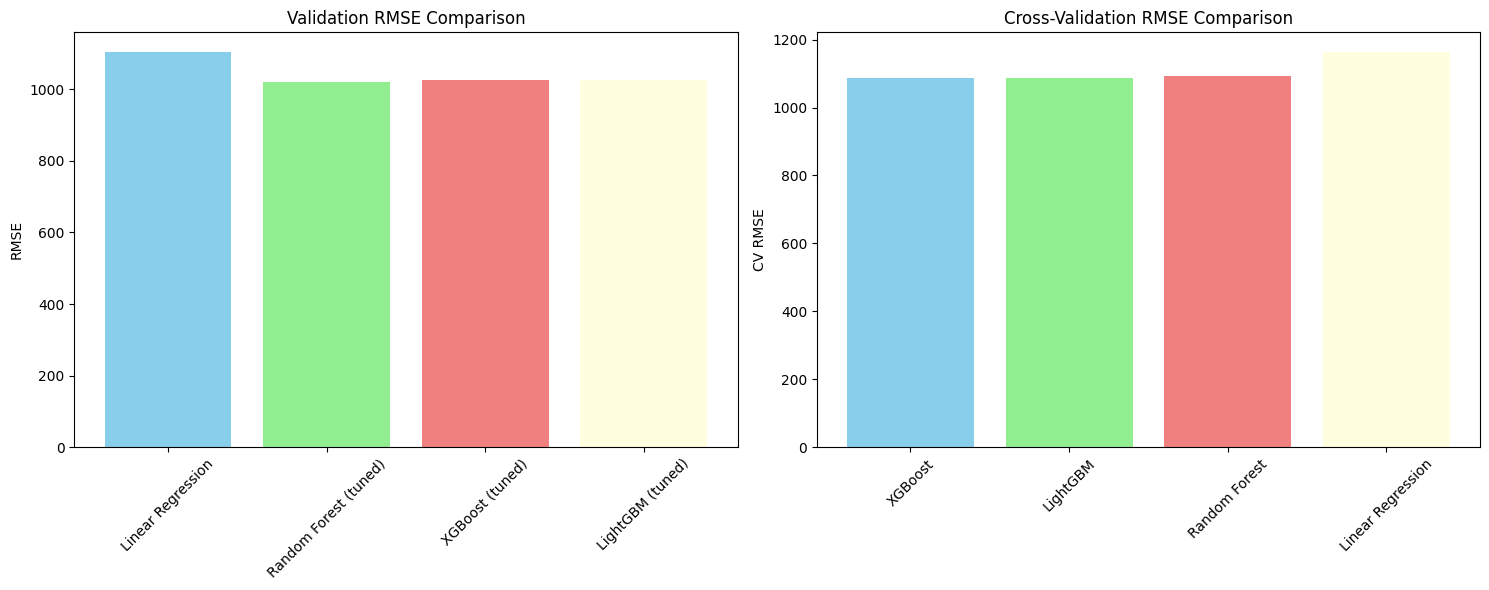


Best Model: XGBoost
Best CV RMSE: 1088.0773


In [9]:
# Create comparison dataframe
results_df = pd.DataFrame(model_results)
print("Model Performance Comparison:")
print(results_df.round(4))

# Cross-validation results comparison
print("\nCross-Validation RMSE Comparison:")
cv_comparison = pd.DataFrame(list(cv_results.items()), columns=['Model', 'CV_RMSE'])
cv_comparison = cv_comparison.sort_values('CV_RMSE')
print(cv_comparison)

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Validation RMSE comparison
axes[0].bar(results_df['model_name'], results_df['val_rmse'], 
            color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
axes[0].set_title('Validation RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# Cross-validation RMSE comparison
axes[1].bar(cv_comparison['Model'], cv_comparison['CV_RMSE'],
            color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
axes[1].set_title('Cross-Validation RMSE Comparison')
axes[1].set_ylabel('CV RMSE')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Select best model based on CV RMSE
best_model_name = cv_comparison.iloc[0]['Model']
best_cv_score = cv_comparison.iloc[0]['CV_RMSE']

print(f"\nBest Model: {best_model_name}")
print(f"Best CV RMSE: {best_cv_score:.4f}")

# Map model name to actual model object
model_mapping = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model
}

best_model = model_mapping[best_model_name]


Top 10 Feature Importances for XGBoost:
                      feature  importance
4                    Item_MRP    0.346297
8                 Outlet_Type    0.300008
5   Outlet_Establishment_Year    0.246364
11  Item_Visibility_MeanRatio    0.025067
13      Price_per_Unit_Weight    0.019778
2             Item_Visibility    0.016395
3                   Item_Type    0.014143
6                 Outlet_Size    0.012612
0                 Item_Weight    0.009563
14           Outlet_Type_Size    0.009470


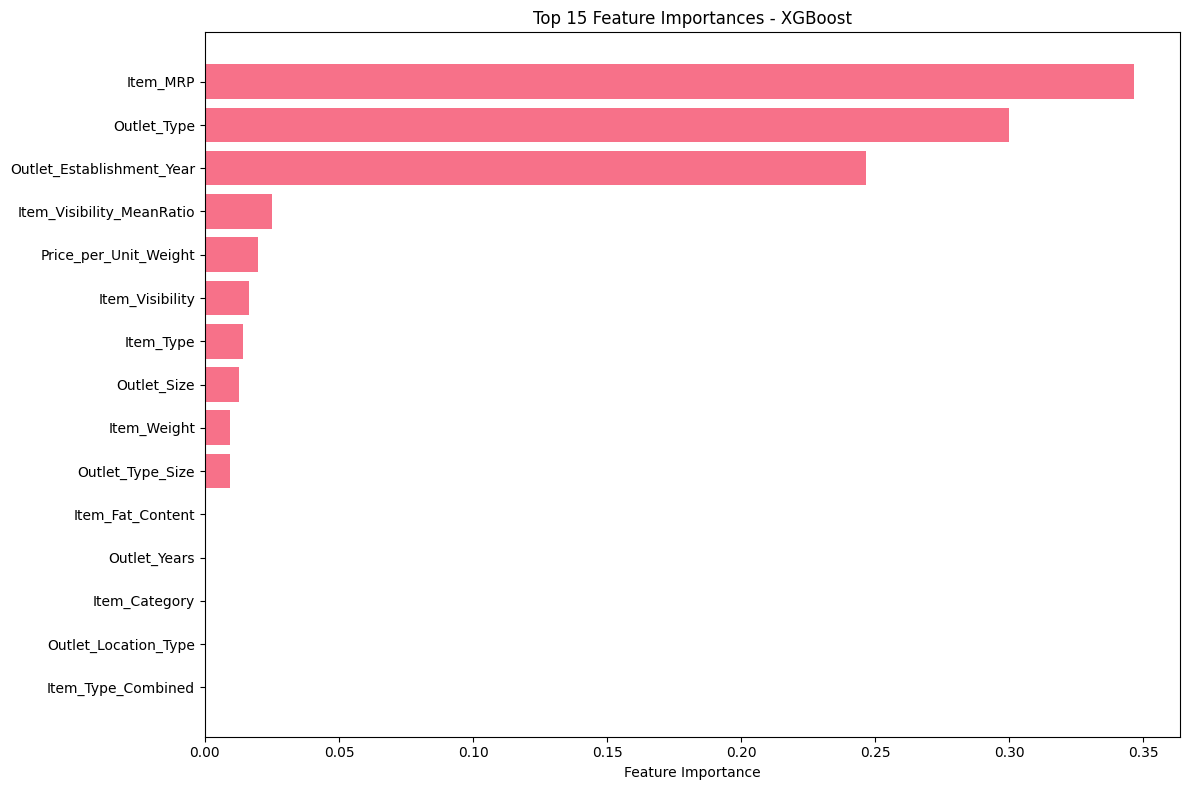

In [10]:
# Feature importance analysis for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"Top 10 Feature Importances for {best_model_name}:")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_name} does not have feature_importances_ attribute")

# Model coefficients for Linear Regression
if hasattr(best_model, 'coef_'):
    feature_coef = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.coef_
    }).sort_values('coefficient', ascending=False, key=abs)
    
    print(f"Top 10 Feature Coefficients for {best_model_name}:")
    print(feature_coef.head(10))


In [11]:
# Train final model on full dataset
print(f"Training final {best_model_name} model on full dataset...")
final_model = best_model
final_model.fit(X, y)

# Final model evaluation
y_full_pred = final_model.predict(X)
final_rmse = calculate_rmse(y, y_full_pred)
final_r2 = r2_score(y, y_full_pred)

print(f"\nFinal Model Performance on Full Dataset:")
print(f"RMSE: {final_rmse:.4f}")
print(f"R²: {final_r2:.4f}")

# Save the best model
joblib.dump(final_model, 'models/best_model.pkl')
print(f"\nBest model ({best_model_name}) saved as 'models/best_model.pkl'")

# Save model comparison results
results_df.to_csv('models/model_comparison.csv', index=False)
print("Model comparison results saved as 'models/model_comparison.csv'")


Training final XGBoost model on full dataset...

Final Model Performance on Full Dataset:
RMSE: 1074.2094
R²: 0.6037

Best model (XGBoost) saved as 'models/best_model.pkl'
Model comparison results saved as 'models/model_comparison.csv'


In [12]:
# Model training summary
print("Model Training Summary:")
print("=" * 50)
print(f"Best Model: {best_model_name}")
print(f"Cross-Validation RMSE: {best_cv_score:.4f}")
print(f"Final Model RMSE: {final_rmse:.4f}")
print(f"Final Model R²: {final_r2:.4f}")
print("\nFiles saved:")
print("- models/best_model.pkl")
print("- models/model_comparison.csv")
print("=" * 50)


Model Training Summary:
Best Model: XGBoost
Cross-Validation RMSE: 1088.0773
Final Model RMSE: 1074.2094
Final Model R²: 0.6037

Files saved:
- models/best_model.pkl
- models/model_comparison.csv
